In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import statsmodels.api as sm
#importing the necessary libraries
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

# To use this experimental feature, we need to explicitly ask for it:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import SimpleImputer, MissingIndicator, KNNImputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import FeatureUnion, make_pipeline
from sklearn import preprocessing
from sklearn.model_selection import train_test_split,cross_val_score

N_SPLITS = 5

rng = np.random.RandomState(0)



In [2]:
data_1=pd.read_csv('dataset.csv')
data_2=pd.read_csv('UnicefDataset2.csv')
#data_1.columns = [''] * len(data_1.columns)
data_1 = data_1.replace('NaN', np.nan)
data_1 = data_1.replace('âˆ’', np.nan)
data_1['Happy Planet Index'] = np.nan
countries=list(data_1['Country'])

data_1

,Country,Region,Gross National Income (GNI),fin_inc_male,fin_inc_female,urban_labour_part_male,urban_labour_part_female,rural_labour_part_male,rural_labour_part_female,total_labour_part_male,total_labour_part_female,family_planning_demand_female(15-49),family_planning_demand_female(15-19),gov_exp_health,gov_exp_education,births_by_18,Happy Planet Index
0,Afghanistan,Middle East and North Africa,Low,23.0,7.0,71.0,16.0,74.0,23.0,73.0,21.0,42.0,21.0,0.5,3.2,20.0,NaN
1,Albania,Post-communist,Upper-Middle,42.0,38.0,NaN,NaN,NaN,NaN,NaN,NaN,5.0,5.0,2.9,3.4,3.0,NaN
2,Algeria,Middle East and North Africa,Upper-Middle,56.0,29.0,57.0,15.0,65.0,10.0,60.0,13.0,77.0,NaN,4.9,NaN,1.0,NaN
3,Andorra,Europe,High,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,3.3,NaN,NaN
4,Angola,Sub Saharan Africa,Lower-Middle,36.0,22.0,73.0,63.0,89.0,90.0,80.0,75.0,30.0,15.0,1.4,3.5,38.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,Venezuela,Americas,Upper-Middle,77.0,70.0,69.0,46.0,76.0,32.0,69.0,45.0,NaN,NaN,2.0,NaN,24.0,NaN
198,Vietnam,Asia Pacific,Lower-Middle,31.0,30.0,74.0,63.0,85.0,77.0,81.0,72.0,70.0,60.0,2.4,5.7,5.0,NaN
199,Yemen,Middle East and North Africa,Low,11.0,2.0,66.0,8.0,65.0,5.0,65.0,6.0,38.0,22.0,0.6,NaN,17.0,NaN
200,Zambia,Sub Saharan Africa,Lower-Middle,52.0,40.0,59.0,36.0,34.0,20.0,45.0,28.0,62.0,57.0,2.1,NaN,31.0,NaN


In [3]:
happy_planet=pd.read_excel('hpi-data-2016.xlsx',sheet_name=4)
happy_planet=happy_planet[0:140]
del happy_planet['Unnamed: 0']
happy_planet=happy_planet.sort_values(by=['Country'])
happy_planet = happy_planet.replace('Data unavailable', np.nan)
happy_planet.head()

,HPI Rank,Country,Region,Average Life \nExpectancy,Average Wellbeing\n(0-10),Happy Life Years,Footprint\n(gha/capita),Inequality of Outcomes,Inequality-adjusted Life Expectancy,Inequality-adjusted Wellbeing,Happy Planet Index,GDP/capita\n($PPP),Population,GINI index
0,110.0,Afghanistan,Middle East and North Africa,59.668,3.8,12.396024,0.79,0.426557,38.348818,3.390494,20.225350,690.842629,29726803.0,NaN
1,13.0,Albania,Post-communist,77.347,5.5,34.414736,2.21,0.165134,69.671159,5.097650,36.766874,4247.485437,2900489.0,28.96
2,30.0,Algeria,Middle East and North Africa,74.313,5.6,30.469461,2.12,0.244862,60.474545,5.196449,33.300543,5583.616160,37439427.0,NaN
3,19.0,Argentina,Americas,75.927,6.5,40.166674,3.14,0.164238,68.349583,6.034707,35.190244,14357.411589,42095224.0,42.49
4,73.0,Armenia,Post-communist,74.446,4.3,24.018760,2.23,0.216648,66.921682,3.747140,25.666417,3565.517575,2978339.0,30.48


In [4]:
#Find countries that have Happy Planet Index
for i in range(len(happy_planet.index)):
    country=happy_planet['Country'][i]
    if country in countries:
        c=data_1[data_1.Country.str.contains(country,case=False)].index
        data_1['Happy Planet Index'][c]=happy_planet['Happy Planet Index'][i]
#Remove rows with all NaN values

data_1=data_1.drop(columns=['Country','Region','Gross National Income (GNI)'])

def assess_NA(data):
    """
    Returns a pandas dataframe denoting the total number of NA values and the percentage of NA values in each column.
    The column names are noted on the index.
    
    Parameters
    ----------
    data: dataframe
    """
    # pandas series denoting features and the sum of their null values
    null_sum = data.isnull().sum()# instantiate columns for missing data
    total = null_sum.sort_values(ascending=False)
    percent = ( ((null_sum / len(data.index))*100).round(2) ).sort_values(ascending=False)
    
    # concatenate along the columns to create the complete dataframe
    df_NA = pd.concat([total, percent], axis=1, keys=['Number of NA', 'Percent NA'])
    
    # drop rows that don't have any missing data; omit if you want to keep all rows
    df_NA = df_NA[ (df_NA.T != 0).any() ]
    
    return df_NA


data_1

/Users/conorbarrycullen/miniconda3/envs/stan/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,fin_inc_male,fin_inc_female,urban_labour_part_male,urban_labour_part_female,rural_labour_part_male,rural_labour_part_female,total_labour_part_male,total_labour_part_female,family_planning_demand_female(15-49),family_planning_demand_female(15-19),gov_exp_health,gov_exp_education,births_by_18,Happy Planet Index
0,23.0,7.0,71.0,16.0,74.0,23.0,73.0,21.0,42.0,21.0,0.5,3.2,20.0,20.225350
1,42.0,38.0,NaN,NaN,NaN,NaN,NaN,NaN,5.0,5.0,2.9,3.4,3.0,36.766874
2,56.0,29.0,57.0,15.0,65.0,10.0,60.0,13.0,77.0,NaN,4.9,NaN,1.0,33.300543
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,3.3,NaN,NaN
4,36.0,22.0,73.0,63.0,89.0,90.0,80.0,75.0,30.0,15.0,1.4,3.5,38.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,77.0,70.0,69.0,46.0,76.0,32.0,69.0,45.0,NaN,NaN,2.0,NaN,24.0,33.569960
198,31.0,30.0,74.0,63.0,85.0,77.0,81.0,72.0,70.0,60.0,2.4,5.7,5.0,40.307589
199,11.0,2.0,66.0,8.0,65.0,5.0,65.0,6.0,38.0,22.0,0.6,NaN,17.0,NaN
200,52.0,40.0,59.0,36.0,34.0,20.0,45.0,28.0,62.0,57.0,2.1,NaN,31.0,25.224246


In [5]:
trainingData = data_1.iloc[:, :].values
dataset = data_1.iloc[:, :].values

#imputer = SimpleImputer(missing_values=np.nan, strategy="median")
imputer = KNNImputer(missing_values=np.nan, n_neighbors=25, weights="uniform")
#imputer = IterativeImputer(missing_values=np.nan)
imputer = imputer.fit(trainingData[:, 0:14])
dataset[:, 0:14] = imputer.transform(dataset[:, 0:14])

dataset=pd.DataFrame(dataset)
dataset.columns=data_1.columns
dataset

,fin_inc_male,fin_inc_female,urban_labour_part_male,urban_labour_part_female,rural_labour_part_male,rural_labour_part_female,total_labour_part_male,total_labour_part_female,family_planning_demand_female(15-49),family_planning_demand_female(15-19),gov_exp_health,gov_exp_education,births_by_18,Happy Planet Index
0,23,7,71,16,74,23,73,21,42,21,0.5,3.2,20,20.2253
1,42,38,65.32,49.12,70.76,55,68,52.44,5,5,2.9,3.4,3,36.7669
2,56,29,57,15,65,10,60,13,77,40.12,4.9,4.916,1,33.3005
3,68,60.76,68.08,49.8,69.04,43.52,68.12,47.72,64.52,45.12,5,3.3,10.24,26.8505
4,36,22,73,63,89,90,80,75,30,15,1.4,3.5,38,22.6885
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,77,70,69,46,76,32,69,45,60.16,40.56,2,4.684,24,33.57
198,31,30,74,63,85,77,81,72,70,60,2.4,5.7,5,40.3076
199,11,2,66,8,65,5,65,6,38,22,0.6,4.26,17,25.0256
200,52,40,59,36,34,20,45,28,62,57,2.1,4.844,31,25.2242


In [6]:
'''
imputes=[]
happy_imputes=[]
cols=dataset.columns
for i in range(len(cols)):
    column=cols[i]
    # Impute with median on columns
    dataset[column] = dataset[column].fillna( dataset[column].median() )
    happy_imputes.append(dataset['Happy Planet Index'].median())
    imputes.append(dataset[column].median())

'''
y=dataset[['Happy Planet Index']]
X=dataset.drop(columns=['Happy Planet Index'])
X

,fin_inc_male,fin_inc_female,urban_labour_part_male,urban_labour_part_female,rural_labour_part_male,rural_labour_part_female,total_labour_part_male,total_labour_part_female,family_planning_demand_female(15-49),family_planning_demand_female(15-19),gov_exp_health,gov_exp_education,births_by_18
0,23,7,71,16,74,23,73,21,42,21,0.5,3.2,20
1,42,38,65.32,49.12,70.76,55,68,52.44,5,5,2.9,3.4,3
2,56,29,57,15,65,10,60,13,77,40.12,4.9,4.916,1
3,68,60.76,68.08,49.8,69.04,43.52,68.12,47.72,64.52,45.12,5,3.3,10.24
4,36,22,73,63,89,90,80,75,30,15,1.4,3.5,38
...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,77,70,69,46,76,32,69,45,60.16,40.56,2,4.684,24
198,31,30,74,63,85,77,81,72,70,60,2.4,5.7,5
199,11,2,66,8,65,5,65,6,38,22,0.6,4.26,17
200,52,40,59,36,34,20,45,28,62,57,2.1,4.844,31


In [7]:
#X = dataset.drop("Happy Planet Index", 1)       # feature matrix 
#y = dataset['Happy Planet Index']               # target feature
def forward_selection(data, target, significance_level=0.05):
    initial_features = data.columns.tolist()
    best_features = []
    while (len(list(initial_features))>0):
        remaining_features = list(set(initial_features)-set(best_features))
        new_pval = pd.Series(index=remaining_features)
        for new_column in remaining_features:
            model = sm.OLS(target, sm.add_constant(data[best_features+[new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        min_p_value = new_pval.min()
        if(min_p_value<significance_level):
            best_features.append(new_pval.idxmin())
        else:
            break
    return best_features

def backward_elimination(data, target,significance_level = 0.05):
    features = data.columns.tolist()
    while(len(features)>0):
        features_with_constant = sm.add_constant(data[features])
        p_values = sm.OLS(target, features_with_constant).fit().pvalues[1:]
        max_p_value = p_values.max()
        if(max_p_value >= significance_level):
            excluded_feature = p_values.idxmax()
            features.remove(excluded_feature)
        else:
            break 
    return features

print('Forward Selection Best Features: ' + str(forward_selection(X.astype(float),y.astype(float))))
print('Backward Elimination Best Features: ' + str(backward_elimination(X.astype(float),y.astype(float))))



/Users/conorbarrycullen/miniconda3/envs/stan/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Forward Selection Best Features: ['family_planning_demand_female(15-49)', 'rural_labour_part_male', 'rural_labour_part_female', 'gov_exp_health', 'fin_inc_female']
Backward Elimination Best Features: ['fin_inc_female', 'rural_labour_part_male', 'rural_labour_part_female', 'family_planning_demand_female(15-49)', 'gov_exp_health']


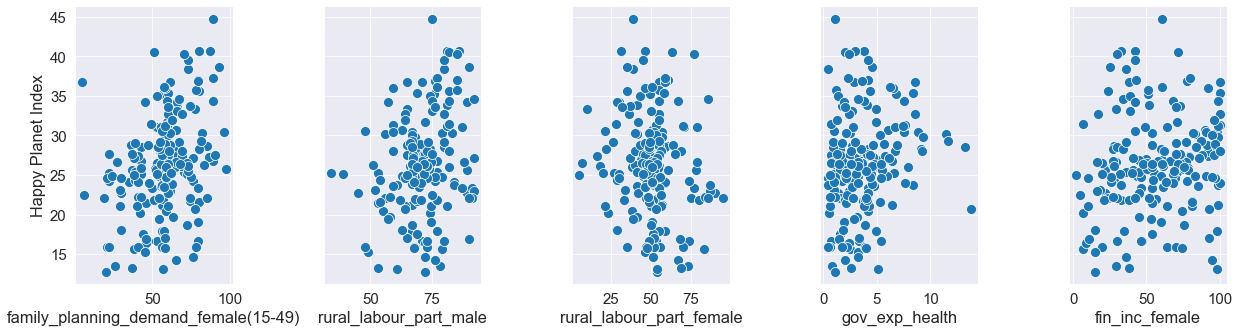

In [8]:
sns.set_context("paper", font_scale=1.7, rc={"lines.linewidth": 2})
sns.set_style('darkgrid',{'legend.frameon':True})
sns.pairplot(dataset, x_vars=forward_selection(X.astype(float),y.astype(float)), y_vars='Happy Planet Index', height=5, aspect=0.7,plot_kws={"s": 100}
)


plt.savefig('best_features.eps', format='eps')

In [9]:
#importing the necessary libraries
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression
# Sequential Forward Selection(sfs)
sfs = SFS(LinearRegression(),
           k_features=(3,13),
           forward=True,
           floating=False,
           scoring = 'r2',
           cv = 0)

sfs.fit(X, y)
sfs.k_feature_names_     # to get the final set of features

('fin_inc_male',
 'fin_inc_female',
 'urban_labour_part_male',
 'urban_labour_part_female',
 'rural_labour_part_male',
 'rural_labour_part_female',
 'total_labour_part_male',
 'total_labour_part_female',
 'family_planning_demand_female(15-49)',
 'family_planning_demand_female(15-19)',
 'gov_exp_health',
 'gov_exp_education',
 'births_by_18')

/Users/conorbarrycullen/miniconda3/envs/stan/lib/python3.6/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/conorbarrycullen/miniconda3/envs/stan/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


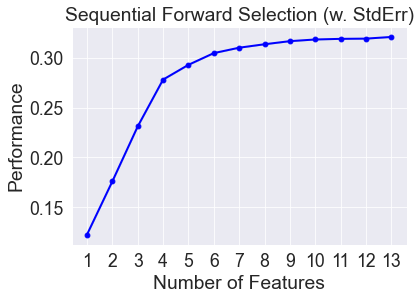

<Figure size 432x288 with 0 Axes>

In [10]:
#Plot the 
sns.set_context("paper", font_scale=2, rc={"lines.linewidth": 2})
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt
ax = plot_sfs(sfs.get_metric_dict(), kind='std_dev')
plt.title('Sequential Forward Selection (w. StdErr)')
plt.show()

plt.savefig('sequence.eps', format='eps')

In [11]:
from sklearn.metrics import accuracy_score
#Multiple Linear Regression
X = dataset[forward_selection(X.astype(float),y.astype(float))]
y = dataset['Happy Planet Index']

# with sklearn
regr = LinearRegression()
regr.fit(X, y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

'''
# Use for predicting new values
New_Family_Planning_Demand=
New_Total_Labour_Part=
print ('Predicted HPI: \n', regr.predict([[New_Family_Planning_Demand ,New_Total_Labour_Part]]))
'''

# with statsmodels
X = sm.add_constant(X) # adding a constant
 
model = sm.OLS(y.astype(float),X.astype(float)).fit()
predictions = model.predict(X) 
 
print_model = model.summary()
print(print_model)
print(metrics.mean_squared_error(y, predictions))




/Users/conorbarrycullen/miniconda3/envs/stan/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Intercept: 
 5.641277587898738
Coefficients: 
 [ 0.07366529  0.28275644 -0.14123645  0.39523063  0.03618234]
                            OLS Regression Results                            
Dep. Variable:     Happy Planet Index   R-squared:                       0.293
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     16.23
Date:                Wed, 13 May 2020   Prob (F-statistic):           2.21e-13
Time:                        14:09:20   Log-Likelihood:                -616.11
No. Observations:                 202   AIC:                             1244.
Df Residuals:                     196   BIC:                             1264.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.9

/Users/conorbarrycullen/miniconda3/envs/stan/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


NameError: name 'metrics' is not defined

In [12]:
from sklearn import linear_model
y=dataset[['Happy Planet Index']]
X=dataset.drop(columns=['Happy Planet Index'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=0)

clf = linear_model.Lasso(alpha=0.1,normalize=True, max_iter=1e5)
predictors=forward_selection(X_train.astype(float),y_train.astype(float))
print(X.columns)
clf.fit(X, y)
print(clf.coef_)
print(clf.intercept_)


y_pred = clf.predict(dataset[X])
print(metrics.mean_squared_error(y, y_pred))
alpha=0.1

plt.tight_layout()
plt.plot(dataset['gov_exp_health'],y_pred)
plt.plot(dataset['gov_exp_health'],dataset['Happy Planet Index'],'.')
plt.title('Plot for alpha: %.3g'%alpha)

Index(['fin_inc_male', 'fin_inc_female', 'urban_labour_part_male',
       'urban_labour_part_female', 'rural_labour_part_male',
       'rural_labour_part_female', 'total_labour_part_male',
       'total_labour_part_female', 'family_planning_demand_female(15-49)',
       'family_planning_demand_female(15-19)', 'gov_exp_health',
       'gov_exp_education', 'births_by_18'],
      dtype='object')
[ 0.          0.          0.         -0.          0.00992863 -0.
  0.         -0.          0.04114362  0.          0.          0.
 -0.        ]
[23.20784744]


ValueError: Must pass DataFrame with boolean values only

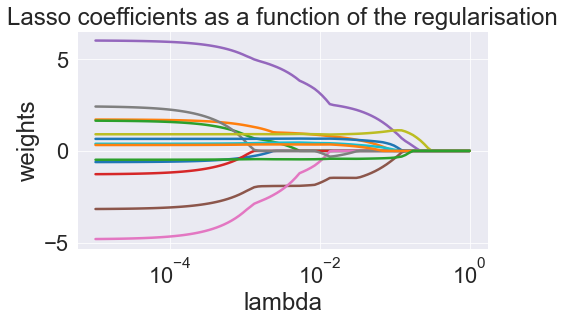

In [13]:
sns.set_context("paper", font_scale=2.5, rc={"lines.linewidth": 2.5})

alphas = 10**np.linspace(-5,0,100)*0.5

lasso = linear_model.Lasso(max_iter = 10000, normalize = True)
coefs = []

from sklearn.preprocessing import scale 

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(scale(X), y)
    coefs.append(lasso.coef_)
    
fig = plt.subplots(figsize=(8,5))
ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('lambda')
plt.ylabel('weights')
plt.title("Lasso coefficients as a function of the regularisation")
plt.tight_layout()

plt.savefig('lasso_coeffs.eps', format='eps')

Text(0.5, 1.0, 'Coefficients in the Lasso Model')

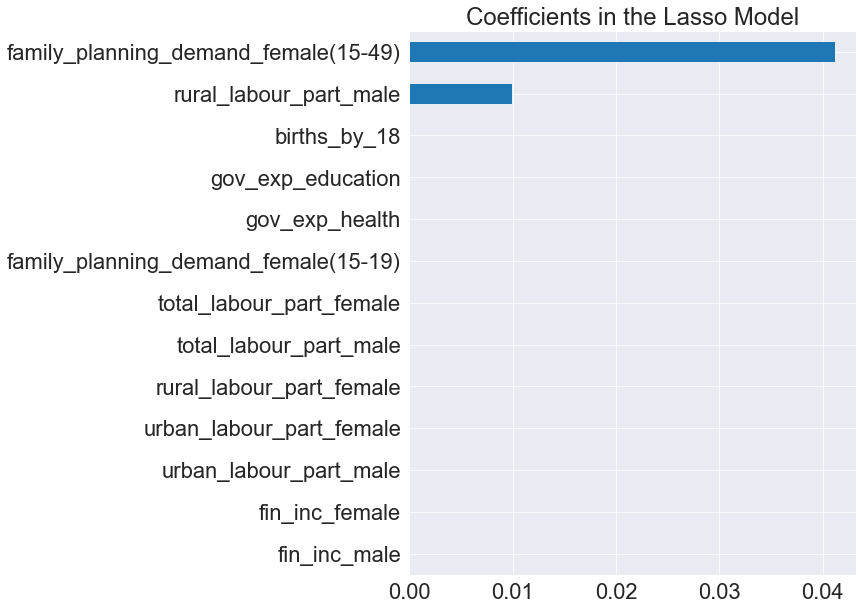

In [14]:
coef = pd.Series(clf.coef_, index = X.columns)

imp_coef = pd.concat([coef.sort_values()])
plt.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

[312372.33479199 379365.4697119    5307.79222505]
the r-squared is:  0.17608092695654287
the coefficient (value of a) for family planning demand, rural, constant is:  [0.1181293  0.14013042 9.55588809]
r-squared value of 0.17608092695654287


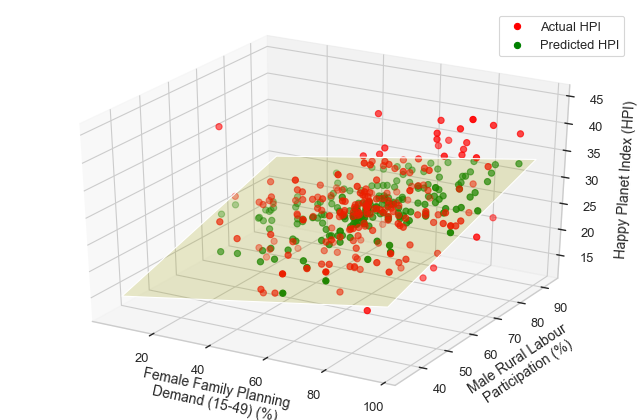

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
sns.set_context("paper", font_scale=1.05, rc={"lines.linewidth": 2})
sns.set_style('whitegrid',{'legend.frameon':True})


# create arrays for the data points

# create arrays for the data points
X = []
Y = []

for i in range(202):
    x1=dataset['family_planning_demand_female(15-49)'][i]
    x2=dataset['rural_labour_part_male'][i]
    y=dataset['Happy Planet Index'][i]
    X.append([float(x1), float(x2), 1]) # add the bias term at the end
    Y.append(float(y))

# use numpy arrays so that we can use linear algebra later
X = np.array(X)
Y = np.array(Y)


# Use Linear Algebra to solve
print(np.dot(X.T, Y))
a = np.linalg.solve(np.dot(X.T, X), np.dot(X.T, Y))
predictedY = np.dot(X, a)

# calculate the r-squared
SSres = Y - predictedY
SStot = Y - Y.mean()
rSquared = 1 - (SSres.dot(SSres) / SStot.dot(SStot))
print("the r-squared is: ", rSquared)
print("the coefficient (value of a) for family planning demand, rural, constant is: ", a)

# create a wiremesh for the plane that the predicted values will lie
xx, yy, zz = np.meshgrid(X[:, 0], X[:, 1], X[:, 2])
combinedArrays = np.vstack((xx.flatten(), yy.flatten(), zz.flatten())).T
Z = combinedArrays.dot(a)


# calculate r-squared error given weights

Yhat = predictedY
d1 = Y - Yhat
d2 = Y - Y.mean()
r2 = 1 - d1.dot(d1) / d2.dot(d2)
print("r-squared value of", r2)

# calculate plane of best fit
divs = 2 # number of divisions in surface: generates divs^2 points.
         # The surface is a plane, so just 2^2 = 4 points can define it.
# plane spans all values of x1 and x2 from data
x1_range = np.linspace(min(X[:,0]),max(X[:,0]),divs)
x2_range = np.linspace(min(X[:,1]),max(X[:,1]),divs)
X_plane = []
for i in range(divs):
    for j in range(divs):
        X_plane.append([x1_range[i], x2_range[j],1])
X_plane = np.array(X_plane)
# values of y are equal to the linear regression of points on the plane
Yhat2 = X_plane.dot(a)

# rearrange Yhat2 into a coordinate matrix for display as a surface
Yhat2_surface = []
for i in range(divs):
    Yhat2_surface.append(Yhat2[ divs*i : divs*i+divs ])
Yhat2_surface = np.array(Yhat2_surface)
Yhat2 = Yhat2_surface

# generate coordinate matrices for x1 and x2 values
X1, X2 = np.meshgrid(x1_range, x2_range) # intentional ordering: X2, *then* X1

# plot results
#fig = plt.figure(figsize=(12,12))
fig = plt.figure(figsize=(6.51, 4.31), dpi=100)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], Y, color='r', label='Actual HPI')
ax.scatter(X[:, 0], X[:, 1], predictedY, color='g', label='Predicted HPI')
ax.plot_surface(X1, X2, Yhat2, color='y', alpha=0.2) # plane of best fit
ax.set_xlabel('Female Family Planning\n Demand (15-49) (%)', labelpad=6)
ax.set_ylabel('Male Rural Labour\n Participation (%)',labelpad=6)
ax.set_zlabel('Happy Planet Index (HPI)',rotation=90, labelpad=5)

plt.tight_layout()
ax.legend()
plt.savefig('reg3d.pdf',format='pdf')


plt.show()

